In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

# パスをGoogleドライブ内のものに変更}
# （例：マイドライブの直下に置いた場合）
file_path = '/content/drive/MyDrive/data_lowF_noise.pickle'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# データが読み込めたか確認
# print(data)

In [ ]:
from pathlib import Path
from google.colab import drive

# Google Drive をマウント
drive.mount('/content/drive')

# 学習結果の保存先（好きなフォルダ名でOK）
BASE_OUT_DIR = Path("/content/drive/MyDrive/noise_point_output")
BASE_OUT_DIR.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
############################################################
# 0. imports
############################################################
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

import matplotlib.pyplot as plt


############################################################
# 1. ノイズ生成関数（全部このノートブック内に定義）
############################################################

# ------- 電源ノイズ（50 Hz 高調波 + 2 kHz スイッチング） -------
def add_power_supply_noise(psd_data, interval_idx, noise_level=0.1, num_intervals=30,
                           freq_min=0.0, freq_max=15000.0):
    """
    psd_data: torch.Tensor (L,)
    """
    noisy_data = psd_data.clone()
    num_points = len(psd_data)

    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    base_amplitude = psd_data.mean() * noise_level

    # 電源周波数と高調波
    power_freq = 50.0
    harmonics = [1, 2, 3]  # 50, 100, 150 Hz
    amplitudes = [0.8, 0.4, 0.2]

    for h, amp in zip(harmonics, amplitudes):
        freq = power_freq * h
        sigma = 10.0  # 10 Hz 幅
        peak = amp * base_amplitude * torch.exp(-0.5 * ((frequencies - freq) / sigma) ** 2)
        noisy_data += peak

    # スイッチングノイズ (2 kHz)
    switching_freq = 2000.0
    sigma = 100.0
    peak = 0.6 * base_amplitude * torch.exp(-0.5 * ((frequencies - switching_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data, 0, num_points


# ------- 干渉ノイズ（3 kHz ピーク） -------
def add_interference_noise(psd_data, interval_idx, noise_level=0.1, num_intervals=30,
                           freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)

    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    interference_freq = 3000.0
    base_amplitude = psd_data.mean() * noise_level

    sigma = 10.0
    peak = base_amplitude * torch.exp(-0.5 * ((frequencies - interference_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data, 0, num_points


# ------- クロックリーク（5 kHz ピーク） -------
def add_clock_leakage_noise(psd_data, interval_idx, noise_level=0.1, num_intervals=30,
                            freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)

    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    clock_freq = 5000.0
    base_amplitude = psd_data.mean() * noise_level

    sigma = 10.0
    peak = base_amplitude * torch.exp(-0.5 * ((frequencies - clock_freq) / sigma) ** 2)
    noisy_data += peak

    return noisy_data, 0, num_points


# ------- 統一インターフェース -------
def add_noise_to_interval(psd_data, interval_idx, noise_type="power_supply",
                          noise_level=0.1, num_intervals=30,
                          freq_min=0.0, freq_max=15000.0):
    if noise_type == "power_supply":
        return add_power_supply_noise(psd_data, interval_idx,
                                      noise_level=noise_level,
                                      num_intervals=num_intervals,
                                      freq_min=freq_min,
                                      freq_max=freq_max)
    elif noise_type == "interference":
        return add_interference_noise(psd_data, interval_idx,
                                      noise_level=noise_level,
                                      num_intervals=num_intervals,
                                      freq_min=freq_min,
                                      freq_max=freq_max)
    elif noise_type == "clock_leakage":
        return add_clock_leakage_noise(psd_data, interval_idx,
                                       noise_level=noise_level,
                                       num_intervals=num_intervals,
                                       freq_min=freq_min,
                                       freq_max=freq_max)
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")


############################################################
# 2. 実験環境っぽい「構造化ノイズ」（位置依存ガウス + ソフトクリップ）
############################################################

def process_noise(noise, clip_range=0.5, smoothing_factor=0.1):
    """
    tanhクリップ + 元ノイズとのブレンドで少し滑らかにする
    """
    scaled_noise = noise / clip_range
    processed = torch.tanh(scaled_noise) * clip_range
    smoothed = processed * (1 - smoothing_factor) + noise * smoothing_factor
    return smoothed


def add_structured_noise(psd_data, clip_range=0.5, smoothing_factor=0.1):
    """
    PSD 全体に「位置依存ガウスノイズ」を乗算的に付与して、
    実験環境での揺らぎっぽさを出す
    """
    device = psd_data.device
    if psd_data.dim() == 1:
        x = psd_data.unsqueeze(0)  # (1, L)
        squeeze_out = True
    else:
        x = psd_data
        squeeze_out = False

    B, L = x.shape

    pos = torch.linspace(1, L, L, device=device)
    var = 0.2 + 0.1 * pos / 1000.0
    var = torch.clamp(var, max=0.3)
    std = torch.sqrt(var)
    std = std.unsqueeze(0).expand(B, L)

    noise = torch.normal(mean=0.0, std=std).to(device)
    processed = process_noise(noise, clip_range=clip_range, smoothing_factor=smoothing_factor)

    noisy_psd = x * (1.0 + processed)

    if squeeze_out:
        noisy_psd = noisy_psd.squeeze(0)
    return noisy_psd


############################################################
# 3. データセット（点ごとのノイズ検知 + マスク再構成）
############################################################

class NoisePointDataset(Dataset):
    """
    data_lowF_noise.pickle から PSD を読み込み、
    - 全体に構造化ノイズを乗せる
    - さらに 3 種類の外的ノイズから 1 つを選んで追加
    - 差分から「ノイズが強い点」を 1、それ以外を 0 としてラベリング
    - ランダムにクリーンな点の 15% をマスクして入力とする
    """
    def __init__(
        self,
        pickle_path: str,
        mask_ratio: float = 0.15,
        noise_level: float = 0.3,
        use_random_noise: bool = True,
        fixed_noise_type: str = "power_supply",
        structured_noise_clip_range: float = 0.5,
        structured_noise_smoothing_factor: float = 0.1,
        noise_threshold_k: float = 1.0,   # 差分の mean + k*std をしきい値に
        freq_min: float = 0.0,
        freq_max: float = 15000.0,
    ):
        super().__init__()

        self.pickle_path = Path(pickle_path)
        self.mask_ratio = mask_ratio
        self.noise_level = noise_level
        self.use_random_noise = use_random_noise
        self.fixed_noise_type = fixed_noise_type
        self.noise_types = ["power_supply", "interference", "clock_leakage"]
        self.structured_noise_clip_range = structured_noise_clip_range
        self.structured_noise_smoothing_factor = structured_noise_smoothing_factor
        self.noise_threshold_k = noise_threshold_k
        self.freq_min = freq_min
        self.freq_max = freq_max

        # ------- データ読み込み -------
        with open(self.pickle_path, "rb") as f:
            data = pickle.load(f)

        if isinstance(data, dict):
            # 想定: data["x"] に PSD が入っている構造
            self.x = np.asarray(data["x"], dtype=np.float32)
        else:
            self.x = np.asarray(data, dtype=np.float32)

        # (N, 1, L) → (N, L)
        if self.x.ndim == 3 and self.x.shape[1] == 1:
            self.x = self.x.squeeze(1)

        assert self.x.ndim == 2, f"data shape must be (N, L), got {self.x.shape}"
        self.seq_len = self.x.shape[1]

        # スケールファクタ & 正規化統計（ログ後の mean/std）
        self.scale_factor = 2.5e24
        print("全データセットの正規化統計を計算中...")
        self.normalization_mean, self.normalization_std = self._compute_global_normalization_stats()
        print(f"  normalization_mean = {self.normalization_mean:.6f}")
        print(f"  normalization_std  = {self.normalization_std:.6f}")

        print(f"Dataset loaded:")
        print(f"  Samples: {len(self.x)}")
        print(f"  Sequence length: {self.seq_len}")
        print(f"  Mask ratio: {self.mask_ratio}")
        print(f"  Noise level: {self.noise_level}")
        print(f"  Use random noise type: {self.use_random_noise}")

    def _compute_global_normalization_stats(self, num_samples_for_stats: int = 1000):
        """
        ノイズ付与 + ログ変換後の値から mean / std を計算
        """
        N = len(self.x)
        num = min(num_samples_for_stats, N)
        np.random.seed(42)
        indices = np.random.choice(N, size=num, replace=False)

        log_list = []

        for idx in indices:
            base_psd = self.x[idx].astype(np.float32)
            base_psd = np.nan_to_num(base_psd, nan=0.0, posinf=0.0, neginf=0.0)
            base_t = torch.from_numpy(base_psd)

            # 構造化ノイズ
            structured = add_structured_noise(
                base_t,
                clip_range=self.structured_noise_clip_range,
                smoothing_factor=self.structured_noise_smoothing_factor,
            )

            # 外的ノイズ
            if self.use_random_noise:
                noise_type = np.random.choice(self.noise_types)
            else:
                noise_type = self.fixed_noise_type

            noisy_t, _, _ = add_noise_to_interval(
                structured,
                interval_idx=0,  # 周波数版なので使われない
                noise_type=noise_type,
                noise_level=self.noise_level,
                freq_min=self.freq_min,
                freq_max=self.freq_max,
            )

            noisy = noisy_t.numpy()
            scaled = noisy * self.scale_factor
            scaled = np.maximum(scaled, 1e-30)
            log_vals = np.log(scaled)
            log_list.append(log_vals)

        all_log = np.concatenate(log_list, axis=0)
        mean = float(all_log.mean())
        std = float(all_log.std())
        if std < 1e-6:
            std = 1.0
        return mean, std

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        base_psd = self.x[idx].astype(np.float32)
        base_psd = np.nan_to_num(base_psd, nan=0.0, posinf=0.0, neginf=0.0)
        L = base_psd.shape[0]

        base_t = torch.from_numpy(base_psd)

        # 1. 構造化ノイズ（実験環境）
        structured = add_structured_noise(
            base_t,
            clip_range=self.structured_noise_clip_range,
            smoothing_factor=self.structured_noise_smoothing_factor,
        )

        # 2. ノイズタイプ決定
        if self.use_random_noise:
            noise_type = np.random.choice(self.noise_types)
        else:
            noise_type = self.fixed_noise_type

        # 3. 外的ノイズ付与
        noisy_t, _, _ = add_noise_to_interval(
            structured,
            interval_idx=0,
            noise_type=noise_type,
            noise_level=self.noise_level,
            freq_min=self.freq_min,
            freq_max=self.freq_max,
        )

        # 4. 差分から「ノイズ点」を決める
        diff = (noisy_t - structured).abs()  # (L,)
        diff_mean = diff.mean()
        diff_std = diff.std()
        threshold = diff_mean + self.noise_threshold_k * diff_std

        noise_mask = diff > threshold  # True: ノイズが強い点
        if noise_mask.sum() == 0:
            # 万が一全部 False のときは上位5%をノイズとみなす
            k = max(1, int(0.05 * L))
            topk = torch.topk(diff, k).indices
            noise_mask[topk] = True

        noise_labels = noise_mask.float()  # 1.0 / 0.0

        # 5. マスクポジション（クリーンな点の一部をマスク）
        clean_indices = (~noise_mask).nonzero(as_tuple=False).squeeze(-1)
        if len(clean_indices) > 0:
            num_mask = max(1, int(len(clean_indices) * self.mask_ratio))
            mask_indices = np.random.choice(clean_indices.cpu().numpy(),
                                            size=num_mask,
                                            replace=False)
        else:
            # 全部ノイズ扱いになってしまった場合は何もしない
            mask_indices = np.array([], dtype=np.int64)

        mask_positions = torch.zeros(L, dtype=torch.bool)
        if len(mask_indices) > 0:
            mask_positions[mask_indices] = True

        noisy = noisy_t.numpy()
        masked_noisy = noisy.copy()
        masked_noisy[mask_positions.numpy()] = 0.0

        # 6. スケーリング + ログ + 正規化
        noisy_scaled = noisy * self.scale_factor
        masked_scaled = masked_noisy * self.scale_factor

        noisy_scaled = np.maximum(noisy_scaled, 1e-30)
        masked_scaled = np.maximum(masked_scaled, 1e-30)

        noisy_log = np.log(noisy_scaled)
        masked_log = np.log(masked_scaled)

        noisy_norm = (noisy_log - self.normalization_mean) / (self.normalization_std + 1e-8)
        masked_norm = (masked_log - self.normalization_mean) / (self.normalization_std + 1e-8)

        return {
            "input": torch.tensor(masked_norm, dtype=torch.float32),      # (L,)
            "target": torch.tensor(noisy_norm, dtype=torch.float32),     # (L,)
            "mask": mask_positions,                                      # (L,) bool
            "noise_label": noise_labels.to(torch.float32),               # (L,) 0/1
        }


############################################################
# 4. BERT風モデル（点ごとのノイズ検知 + マスク再構成）
############################################################

class NoisePointBERT(nn.Module):
    def __init__(
        self,
        seq_len: int,
        d_model: int = 64,
        n_heads: int = 2,
        num_layers: int = 2,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # スカラー値 → d_model
        self.value_proj = nn.Linear(1, d_model)

        # 位置埋め込み（[CLS] 分 +1）
        self.pos_embed = nn.Embedding(seq_len + 1, d_model)

        # [CLS] & [MASK] トークン
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # (B, L, E)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 再構成ヘッド（各点の値）
        self.recon_head = nn.Linear(d_model, 1)

        # ノイズ検知ヘッド（各点のノイズ確率）
        self.noise_head = nn.Linear(d_model, 1)

    def forward(self, x, mask_positions):
        """
        x: (B, L)   正規化済みの入力（マスクされた値は0）
        mask_positions: (B, L) bool
        """
        B, L = x.shape
        assert L == self.seq_len

        # (B, L, 1) → (B, L, d_model)
        x_embed = self.value_proj(x.unsqueeze(-1))  # (B, L, d_model)

        # マスクされた位置は mask_token で置き換え
        x_embed = torch.where(
            mask_positions.unsqueeze(-1),
            self.mask_token.expand(B, L, -1),
            x_embed,
        )

        # 位置埋め込み
        pos_ids = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        pos_embed = self.pos_embed(pos_ids)
        x_embed = x_embed + pos_embed

        # CLS 付与
        cls = self.cls_token.expand(B, 1, -1)       # (B, 1, d_model)
        x_with_cls = torch.cat([cls, x_embed], dim=1)  # (B, L+1, d_model)

        # Transformer
        encoded = self.encoder(x_with_cls)  # (B, L+1, d_model)

        # シーケンス部（各点）
        encoded_seq = encoded[:, 1:, :]  # (B, L, d_model)

        # 再構成
        recon = self.recon_head(encoded_seq).squeeze(-1)      # (B, L)

        # ノイズ検知
        noise_logits = self.noise_head(encoded_seq).squeeze(-1)  # (B, L)

        return recon, noise_logits


############################################################
# 5. 学習ループ
############################################################

def train_noise_point_task(
    pickle_path: str,
    out_dir: str = "noise_point_output",
    batch_size: int = 16,
    num_epochs: int = 10,
    lr: float = 1e-3,
    val_ratio: float = 0.2,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    lambda_cls: float = 1.0,  # ノイズ検知損失の重み
    resume: bool = False,
):

    os.makedirs(out_dir, exist_ok=True)
    checkpoint_path = os.path.join(out_dir, "checkpoint.pth")

    print(f"Using device: {device}")

    # Dataset
    dataset = NoisePointDataset(
        pickle_path=pickle_path,
        mask_ratio=0.15,
        noise_level=0.3,
        use_random_noise=True,
    )
    seq_len = dataset.seq_len

    # Train / Val split
    n_total = len(dataset)
    n_val = max(1, int(n_total * val_ratio))
    n_train = n_total - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    print(f"Train samples: {n_train}, Val samples: {n_val}")

    # Model
    model = NoisePointBERT(
        seq_len=seq_len,
        d_model=64,
        n_heads=2,
        num_layers=2,
        dim_feedforward=128,
    ).to(device)

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = GradScaler(enabled=(device == "cuda"))

    bce_criterion = nn.BCEWithLogitsLoss()

    # ログ用
    start_epoch = 0
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    # 再開
    if resume and os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        scheduler.load_state_dict(ckpt["scheduler_state"])
        start_epoch = ckpt["epoch"] + 1
        train_losses = ckpt["train_losses"]
        val_losses = ckpt["val_losses"]
        best_val_loss = ckpt.get("best_val_loss", float("inf"))
        print(f"Resumed from epoch {start_epoch}")

    # 学習ループ
    for epoch in range(start_epoch, num_epochs):
        # ---------------- Train ----------------
        model.train()
        running_loss = 0.0
        running_mask_loss = 0.0
        running_cls_loss = 0.0
        running_cls_acc = 0.0
        total_points = 0

        for batch in train_loader:
            x = batch["input"].to(device)          # (B, L)
            y = batch["target"].to(device)         # (B, L)
            m = batch["mask"].to(device)           # (B, L) bool
            noise_label = batch["noise_label"].to(device)  # (B, L) 0/1

            B, L = x.shape
            total_points += B * L

            optimizer.zero_grad()

            with autocast(enabled=(device == "cuda")):
                recon, noise_logits = model(x, m)

                # マスク再構成 MSE（マスクされた点のみ）
                if m.any():
                    mask_loss = F.mse_loss(recon[m], y[m])
                else:
                    mask_loss = torch.tensor(0.0, device=device)

                # ノイズ検知 BCE
                cls_loss = bce_criterion(
                    noise_logits.view(-1),
                    noise_label.view(-1),
                )

                loss = mask_loss + lambda_cls * cls_loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * B
            running_mask_loss += mask_loss.item() * B
            running_cls_loss += cls_loss.item() * B

            # 精度（ノイズ検知）
            with torch.no_grad():
                probs = torch.sigmoid(noise_logits)
                preds = (probs > 0.5).float()
                correct = (preds == noise_label).float().sum()
                running_cls_acc += correct.item()

        train_loss = running_loss / n_train
        train_mask_loss = running_mask_loss / n_train
        train_cls_loss = running_cls_loss / n_train
        train_cls_acc = running_cls_acc / total_points

        train_losses.append(train_loss)

        # ---------------- Val ----------------
        model.eval()
        val_running_loss = 0.0
        val_running_cls_acc = 0.0
        val_points = 0

        with torch.no_grad():
            for batch in val_loader:
                x = batch["input"].to(device)
                y = batch["target"].to(device)
                m = batch["mask"].to(device)
                noise_label = batch["noise_label"].to(device)

                B, L = x.shape
                val_points += B * L

                with autocast(enabled=(device == "cuda")):
                    recon, noise_logits = model(x, m)

                    if m.any():
                        mask_loss = F.mse_loss(recon[m], y[m])
                    else:
                        mask_loss = torch.tensor(0.0, device=device)

                    cls_loss = bce_criterion(
                        noise_logits.view(-1),
                        noise_label.view(-1),
                    )

                    loss = mask_loss + lambda_cls * cls_loss

                val_running_loss += loss.item() * B

                probs = torch.sigmoid(noise_logits)
                preds = (probs > 0.5).float()
                correct = (preds == noise_label).float().sum()
                val_running_cls_acc += correct.item()

        val_loss = val_running_loss / n_val
        val_cls_acc = val_running_cls_acc / val_points
        val_losses.append(val_loss)

        scheduler.step()

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"Train Loss: {train_loss:.6f} "
            f"(Mask: {train_mask_loss:.6f}, Cls: {train_cls_loss:.6f}, ClsAcc: {train_cls_acc:.4f}) "
            f"Val Loss: {val_loss:.6f} "
            f"(Val ClsAcc: {val_cls_acc:.4f}) "
            f"LR: {scheduler.get_last_lr()[0]:.6e}"
        )

        # best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(out_dir, "best_val_model.pth"))
            print(f"  >> New best val model saved (Val Loss: {val_loss:.6f})")

        # checkpoint
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "train_losses": train_losses,
                "val_losses": val_losses,
                "best_val_loss": best_val_loss,
            },
            checkpoint_path,
        )

    # Loss カーブ保存
    epochs = range(1, len(train_losses) + 1)
    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    curve_path = os.path.join(out_dir, "loss_curve.png")
    plt.savefig(curve_path)
    plt.close()
    print(f"Loss curve saved to {curve_path}")

    final_model_path = os.path.join(out_dir, "final_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")

    return model, train_losses, val_losses, best_val_loss


############################################################
# 6. 実行例
############################################################

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device: {device}")

    # ★ここを自分の Drive 上の data_lowF_noise.pickle パスに変更★
    PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"

    model, train_losses, val_losses, best_val_loss = train_noise_point_task(
        pickle_path=PICKLE_PATH,
        out_dir=str(BASE_OUT_DIR),   # ← ここを変更！,
        batch_size=16,
        num_epochs=100,
        lr=1e-3,
        val_ratio=0.2,
        device=device,
        lambda_cls=1.0,
        resume=True,
    )


Device: cuda
Using device: cuda
全データセットの正規化統計を計算中...
  normalization_mean = -3.063465
  normalization_std  = 0.823113
Dataset loaded:
  Samples: 32000
  Sequence length: 3000
  Mask ratio: 0.15
  Noise level: 0.3
  Use random noise type: True
Train samples: 25600, Val samples: 6400
Resumed from epoch 100
Loss curve saved to /content/drive/MyDrive/noise_point_output/loss_curve.png
Final model saved to /content/drive/MyDrive/noise_point_output/final_model.pth


/tmp/ipython-input-1576826255.py:509: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# =========================
# 1. Dataset を再生成
# =========================

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ★学習のときと同じパスにしてね
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"
OUT_DIR = "noise_point_output"  # 学習時の out_dir と同じ

# 学習時と同じパラメータで Dataset を作る
dataset = NoisePointDataset(
    pickle_path=PICKLE_PATH,
    mask_ratio=0.15,
    noise_level=0.3,
    use_random_noise=True,
)
print("Dataset ready. seq_len =", dataset.seq_len)

# =========================
# 2. モデルを再構築して weight をロード
# =========================

seq_len = dataset.seq_len

model = NoisePointBERT(
    seq_len=seq_len,
    d_model=64,
    n_heads=2,
    num_layers=2,
    dim_feedforward=128,
).to(device)

best_model_path = os.path.join(OUT_DIR, "best_val_model.pth")
print("Loading weights from:", best_model_path)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print("Model loaded & set to eval mode.")


# =========================
# 3. 逆正規化 (norm → PSD) のユーティリティ
# =========================

def denormalize_to_psd(norm_vals, scale_factor, mean, std):
    """
    Dataset 内部で行った
      PSD → *scale_factor → log → (log - mean)/std
    を逆変換して、線形 PSD に戻す。
    norm_vals: numpy array (L,)
    """
    log_vals = norm_vals * std + mean       # log(scaled)
    scaled = np.exp(log_vals)               # scaled PSD
    psd = scaled / scale_factor             # 元の PSD に戻す
    return psd


# =========================
# 4. 可視化関数
# =========================

def visualize_noise_detection_sample(
    model,
    dataset,
    device,
    idx=None,
    save_path=None,
):
    """
    1サンプルのノイズ検知結果を可視化する。

    青線      : ターゲット (ノイズ入り PSD, target)
    黒破線    : 再構成結果 (recon)
    赤バツ    : GT ノイズ点 (noise_label == 1)
    緑丸(抜き): モデルがノイズと判定した点 (pred == 1)
    """
    model.eval()

    # ---- サンプル index 選択 ----
    if idx is None:
        idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]

    x = sample["input"].unsqueeze(0).to(device)             # (1, L)
    y = sample["target"].unsqueeze(0).to(device)            # (1, L)
    m = sample["mask"].unsqueeze(0).to(device)              # (1, L)
    noise_label = sample["noise_label"].unsqueeze(0).to(device)  # (1, L)

    with torch.no_grad():
        recon, noise_logits = model(x, m)
        probs = torch.sigmoid(noise_logits)
        preds = (probs > 0.5).float()

    # CPU / numpy へ
    y_np = y[0].cpu().numpy()             # 正規化済み target noisy
    recon_np = recon[0].cpu().numpy()     # 正規化済み recon
    label_np = noise_label[0].cpu().numpy()
    pred_np = preds[0].cpu().numpy()

    L = len(y_np)
    freqs = np.linspace(dataset.freq_min, dataset.freq_max, L)

    # ---- 正規化をほどいて PSD に戻す ----
    y_psd = denormalize_to_psd(
        y_np,
        dataset.scale_factor,
        dataset.normalization_mean,
        dataset.normalization_std,
    )
    recon_psd = denormalize_to_psd(
        recon_np,
        dataset.scale_factor,
        dataset.normalization_mean,
        dataset.normalization_std,
    )

    # ---- プロット ----
    plt.figure(figsize=(10, 6))

    # 元の noisy PSD と再構成
    plt.plot(freqs, y_psd, label="Target noisy PSD", linewidth=1.0)
    plt.plot(freqs, recon_psd, label="Reconstructed PSD", linewidth=1.0, linestyle="--")

    # 真のノイズ位置 (赤バツ)
    idx_label = np.where(label_np == 1)[0]
    if len(idx_label) > 0:
        plt.scatter(freqs[idx_label], y_psd[idx_label],
                    marker="x", s=40, color="red", label="GT noise points", zorder=3)

    # 予測ノイズ位置 (緑丸)
    idx_pred = np.where(pred_np == 1)[0]
    if len(idx_pred) > 0:
        plt.scatter(freqs[idx_pred], y_psd[idx_pred],
                    facecolors="none", edgecolors="green",
                    marker="o", s=50, label="Pred noise points", zorder=3)

    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD (linear scale)")
    plt.title(f"Noise detection visualization (idx={idx})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print(f"Saved figure to {save_path}")
        plt.close()
    else:
        plt.show()

    return idx  # どのサンプルを描いたか戻しておく


device: cuda
全データセットの正規化統計を計算中...
  normalization_mean = -3.063538
  normalization_std  = 0.823052
Dataset loaded:
  Samples: 32000
  Sequence length: 3000
  Mask ratio: 0.15
  Noise level: 0.3
  Use random noise type: True
Dataset ready. seq_len = 3000
Loading weights from: noise_point_output/best_val_model.pth


FileNotFoundError: [Errno 2] No such file or directory: 'noise_point_output/best_val_model.pth'

In [ ]:
############################################################
# 0. imports
############################################################
import os
import pickle
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt


############################################################
# 1. ノイズ生成（外的ノイズ + 構造化ノイズ）
############################################################

def add_power_supply_noise(psd_data, interval_idx, noise_level=0.1,
                           num_intervals=30, freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)
    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    base_amplitude = psd_data.mean() * noise_level

    # 電源周波数 50 Hz, 100 Hz, 150 Hz
    power_freq = 50.0
    harmonics = [1, 2, 3]
    amplitudes = [0.8, 0.4, 0.2]

    for h, amp in zip(harmonics, amplitudes):
        freq = power_freq * h
        sigma = 10.0
        peak = amp * base_amplitude * torch.exp(-0.5*((frequencies - freq)/sigma)**2)
        noisy_data += peak

    # 2 kHz スイッチングノイズ
    switching_freq = 2000.0
    sigma = 100.0
    peak = 0.6 * base_amplitude * torch.exp(-0.5*((frequencies - switching_freq)/sigma)**2)
    noisy_data += peak

    return noisy_data, 0, num_points


def add_interference_noise(psd_data, interval_idx, noise_level=0.1,
                           num_intervals=30, freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)
    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    base_amplitude = psd_data.mean() * noise_level

    sigma = 10.0
    peak = base_amplitude*torch.exp(-0.5*((frequencies-3000)/sigma)**2)
    noisy_data += peak
    return noisy_data, 0, num_points


def add_clock_leakage_noise(psd_data, interval_idx, noise_level=0.1,
                            num_intervals=30, freq_min=0.0, freq_max=15000.0):
    noisy_data = psd_data.clone()
    num_points = len(psd_data)
    frequencies = torch.linspace(freq_min, freq_max, num_points, device=psd_data.device)
    base_amplitude = psd_data.mean() * noise_level

    sigma = 10.0
    peak = base_amplitude*torch.exp(-0.5*((frequencies-5000)/sigma)**2)
    noisy_data += peak
    return noisy_data, 0, num_points


def add_noise_to_interval(psd_data, interval_idx, noise_type="power_supply",
                          noise_level=0.1, num_intervals=30,
                          freq_min=0.0, freq_max=15000.0):
    if noise_type == "power_supply":
        return add_power_supply_noise(psd_data, interval_idx, noise_level,
                                      num_intervals, freq_min, freq_max)
    elif noise_type == "interference":
        return add_interference_noise(psd_data, interval_idx, noise_level,
                                      num_intervals, freq_min, freq_max)
    elif noise_type == "clock_leakage":
        return add_clock_leakage_noise(psd_data, interval_idx, noise_level,
                                       num_intervals, freq_min, freq_max)
    else:
        raise ValueError("Unknown noise type")


############################################################
# 2. 構造化ノイズ
############################################################

def process_noise(noise, clip_range=0.5, smoothing_factor=0.1):
    scaled = noise / clip_range
    processed = torch.tanh(scaled) * clip_range
    smoothed = processed*(1-smoothing_factor) + noise*smoothing_factor
    return smoothed


def add_structured_noise(psd_data, clip_range=0.5, smoothing_factor=0.1):
    if psd_data.dim()==1:
        x = psd_data.unsqueeze(0)
        squeeze=True
    else:
        x=psd_data
        squeeze=False

    B,L = x.shape
    pos = torch.linspace(1,L,L,device=x.device)
    var = 0.2 + 0.1*(pos/1000)
    var = torch.clamp(var, max=0.3)
    std = torch.sqrt(var).unsqueeze(0).expand(B,L)
    noise = torch.normal(0.0, std).to(x.device)

    processed = process_noise(noise, clip_range, smoothing_factor)
    noisy = x*(1+processed)

    if squeeze:
        noisy=noisy.squeeze(0)
    return noisy


############################################################
# 3. Dataset
############################################################

class NoisePointDataset(Dataset):
    def __init__(
        self,
        pickle_path,
        mask_ratio=0.15,
        noise_level=0.3,
        use_random_noise=True,
        fixed_noise_type="power_supply",
        freq_min=0.0,
        freq_max=15000.0,
    ):
        super().__init__()
        self.mask_ratio=mask_ratio
        self.noise_level=noise_level
        self.use_random_noise=use_random_noise
        self.fixed_noise_type=fixed_noise_type
        self.noise_types=["power_supply","interference","clock_leakage"]
        self.freq_min=freq_min
        self.freq_max=freq_max

        with open(pickle_path,"rb") as f:
            data=pickle.load(f)
        self.x=np.asarray(data["x"],dtype=np.float32)

        if self.x.ndim==3 and self.x.shape[1]==1:
            self.x=self.x.squeeze(1)

        self.scale_factor = 2.5e24
        self.normalization_mean, self.normalization_std = self._compute_stats()
        self.seq_len = self.x.shape[1]

    def _compute_stats(self, num_samples_for_stats=500):
        N=len(self.x)
        idx=np.random.choice(N, size=min(N,num_samples_for_stats), replace=False)
        logs=[]
        for i in idx:
            base = torch.from_numpy(self.x[i])
            structured = add_structured_noise(base)
            nt = np.random.choice(self.noise_types)
            noisy,_,_ = add_noise_to_interval(structured,0,noise_type=nt,
                                              noise_level=self.noise_level,
                                              freq_min=self.freq_min,
                                              freq_max=self.freq_max)
            arr = noisy.numpy()*self.scale_factor
            arr = np.maximum(arr,1e-30)
            logs.append(np.log(arr))
        logs=np.concatenate(logs)
        return float(logs.mean()), float(logs.std())

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        base = torch.from_numpy(self.x[idx])
        structured = add_structured_noise(base)

        if self.use_random_noise:
            nt=np.random.choice(self.noise_types)
        else:
            nt=self.fixed_noise_type

        noisy,_,_ = add_noise_to_interval(structured,0,noise_type=nt,
                                          noise_level=self.noise_level,
                                          freq_min=self.freq_min,
                                          freq_max=self.freq_max)

        diff=(noisy-structured).abs()
        th=diff.mean()+diff.std()
        noise_mask=diff>th
        if noise_mask.sum()==0:
            topk=torch.topk(diff,int(len(diff)*0.05)).indices
            noise_mask[topk]=True

        L=len(diff)
        clean_idx = (~noise_mask).nonzero(as_tuple=False).squeeze(-1)
        mask_positions=torch.zeros(L,dtype=torch.bool)
        if len(clean_idx)>0:
            mnum=max(1,int(len(clean_idx)*self.mask_ratio))
            choice=np.random.choice(clean_idx.numpy(),size=mnum,replace=False)
            mask_positions[choice]=True

        noisy_np=noisy.numpy()
        masked=np.copy(noisy_np)
        masked[mask_positions.numpy()]=0.0

        # 正規化
        def norm(arr):
            arr=arr*self.scale_factor
            arr=np.maximum(arr,1e-30)
            log=np.log(arr)
            return (log-self.normalization_mean)/(self.normalization_std+1e-8)

        noisy_norm = norm(noisy_np)
        masked_norm = norm(masked)

        return {
            "input":torch.tensor(masked_norm,dtype=torch.float32),
            "target":torch.tensor(noisy_norm,dtype=torch.float32),
            "mask":mask_positions,
            "noise_label":noise_mask.float()
        }


############################################################
# 4. NoisePointBERT
############################################################

class NoisePointBERT(nn.Module):
    def __init__(self, seq_len, d_model=64, n_heads=2,
                 num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.seq_len=seq_len
        self.value_proj=nn.Linear(1,d_model)
        self.pos_embed=nn.Embedding(seq_len+1,d_model)
        self.cls_token=nn.Parameter(torch.zeros(1,1,d_model))
        self.mask_token=nn.Parameter(torch.zeros(1,1,d_model))

        enc_layer=nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True)
        self.encoder=nn.TransformerEncoder(enc_layer,num_layers=num_layers)

        self.recon_head=nn.Linear(d_model,1)
        self.noise_head=nn.Linear(d_model,1)

    def forward(self,x,m):
        B,L=x.shape
        x_embed=self.value_proj(x.unsqueeze(-1))
        x_embed=torch.where(
            m.unsqueeze(-1),
            self.mask_token.expand(B,L,-1),
            x_embed
        )
        pos_ids=torch.arange(L,device=x.device).unsqueeze(0).expand(B,L)
        x_embed=x_embed+self.pos_embed(pos_ids)

        cls=self.cls_token.expand(B,1,-1)
        xcat=torch.cat([cls,x_embed],dim=1)

        enc=self.encoder(xcat)
        seq=enc[:,1:,:]
        recon=self.recon_head(seq).squeeze(-1)
        noise=self.noise_head(seq).squeeze(-1)
        return recon,noise


############################################################
# 5. モデル読み込み & Dataset準備
############################################################

device="cuda" if torch.cuda.is_available() else "cpu"
PICKLE_PATH="/content/drive/MyDrive/data_lowF_noise.pickle"
OUT_DIR="noise_point_output"

dataset=NoisePointDataset(
    pickle_path=PICKLE_PATH,
    mask_ratio=0.15,
    noise_level=0.3,
    use_random_noise=True,
)

model=NoisePointBERT(seq_len=dataset.seq_len).to(device)
model.load_state_dict(torch.load(
    os.path.join(OUT_DIR,"best_val_model.pth"),
    map_location=device
))
model.eval()


############################################################
# 6. 逆正規化ユーティリティ
############################################################

def denormalize_to_psd(norm_vals, scale_factor, mean, std):
    log_vals=norm_vals*std+mean
    scaled=np.exp(log_vals)
    return scaled/scale_factor


############################################################
# 7. log–log 可視化関数
############################################################

def visualize_noise_detection_sample_loglog(
    model, dataset, device, idx=None, f_max=3000.0, save_path=None):

    if idx is None:
        idx=np.random.randint(0,len(dataset))
    s=dataset[idx]

    x=s["input"].unsqueeze(0).to(device)
    y=s["target"].unsqueeze(0).to(device)
    m=s["mask"].unsqueeze(0).to(device)
    nl=s["noise_label"].unsqueeze(0).to(device)

    with torch.no_grad():
        recon,logit=model(x,m)
        prob=torch.sigmoid(logit)
        pred=(prob>0.5).float()

    y_np=y[0].cpu().numpy()
    recon_np=recon[0].cpu().numpy()
    nl_np=nl[0].cpu().numpy()
    pred_np=pred[0].cpu().numpy()

    L=len(y_np)
    freqs=np.linspace(1,f_max,L)

    y_psd=denormalize_to_psd(
        y_np,dataset.scale_factor,dataset.normalization_mean,dataset.normalization_std
    )
    recon_psd=denormalize_to_psd(
        recon_np,dataset.scale_factor,dataset.normalization_mean,dataset.normalization_std
    )

    eps=1e-30
    y_psd=np.clip(y_psd,eps,None)
    recon_psd=np.clip(recon_psd,eps,None)

    plt.figure(figsize=(10,6))
    plt.plot(freqs,y_psd,label="Target noisy PSD")
    plt.plot(freqs,recon_psd,"--",label="Reconstructed PSD")

    idx_gt=np.where(nl_np==1)[0]
    if len(idx_gt)>0:
        plt.scatter(freqs[idx_gt],y_psd[idx_gt],color="red",marker="x",s=40,label="GT noise")

    idx_pred=np.where(pred_np==1)[0]
    if len(idx_pred)>0:
        plt.scatter(freqs[idx_pred],y_psd[idx_pred],
                    facecolors="none",edgecolors="green",s=40,marker="o",
                    label="Pred noise")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency [Hz] (log)")
    plt.ylabel("PSD (log)")
    plt.title(f"Noise detection sample idx={idx}")
    plt.grid(True,which="both",ls=":")
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path,dpi=200)
        plt.close()
    else:
        plt.show()

    return idx


############################################################
# 8. --- 実行：グラフ表示 ---
############################################################

_ = visualize_noise_detection_sample_loglog(
        model,
        dataset,
        device=device,
        idx=None,
        f_max=3000.0,
        save_path=None
)


FileNotFoundError: [Errno 2] No such file or directory: 'noise_point_output/best_val_model.pth'

In [ ]:
def visualize_noise_detection_sample_loglog(
    model,
    dataset,
    device,
    idx=None,
    f_max=3000.0,
    save_path=None,
):
    """
    log-log (周波数/PSD 両対数) でノイズ検知の様子を可視化。

    青    : ノイズ付加後の PSD (Target noisy)
    オレンジ: 再構成 PSD (Reconstructed)
    グレー : 元のPSD（構造化ノイズ・外的ノイズ付加前）
    赤×   : GT ノイズ点
    緑○   : 予測ノイズ点
    """
    model.eval()

    # --- サンプル index 選択 ---
    if idx is None:
        idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]

    # Dataset から元のPSD（ノイズ付加前）も取り出す
    base_psd = dataset.x[idx].astype(np.float64)  # shape (L,)

    x = sample["input"].unsqueeze(0).to(device)              # (1, L)
    y = sample["target"].unsqueeze(0).to(device)             # (1, L)  ノイズ付加後・正規化済み
    m = sample["mask"].unsqueeze(0).to(device)               # (1, L)
    noise_label = sample["noise_label"].unsqueeze(0).to(device)

    with torch.no_grad():
        recon, noise_logits = model(x, m)
        probs = torch.sigmoid(noise_logits)
        preds = (probs > 0.5).float()

    # --- numpy へ ---
    y_np      = y[0].cpu().numpy()
    recon_np  = recon[0].cpu().numpy()
    label_np  = noise_label[0].cpu().numpy()
    pred_np   = preds[0].cpu().numpy()

    L = len(y_np)

    # 周波数軸：1〜f_max を L 点に等間隔で
    freqs = np.linspace(1.0, f_max, L)

    # ---- 正規化をほどいて PSD に戻す（ノイズ付加後）----
    y_psd = denormalize_to_psd(
        y_np,
        dataset.scale_factor,
        dataset.normalization_mean,
        dataset.normalization_std,
    )
    recon_psd = denormalize_to_psd(
        recon_np,
        dataset.scale_factor,
        dataset.normalization_mean,
        dataset.normalization_std,
    )

    # logスケールに乗せるため、全部クリップ
    eps = 1e-30
    y_psd_clipped     = np.clip(y_psd,     eps, None)
    recon_psd_clipped = np.clip(recon_psd, eps, None)
    base_psd_clipped  = np.clip(base_psd,  eps, None)

    # --- プロット ---
    plt.figure(figsize=(10, 6))

    # 元のPSD（ノイズ付加前）
    plt.plot(freqs, base_psd_clipped,
             label="Original PSD (before synthetic noise)",
             linewidth=1.0, alpha=0.7)

    # ノイズ付加後
    plt.plot(freqs, y_psd_clipped,
             label="Target noisy PSD",
             linewidth=1.0)

    # 再構成
    plt.plot(freqs, recon_psd_clipped,
             label="Reconstructed PSD",
             linewidth=1.0, linestyle="--")

    # GT ノイズ点 (赤×)
    idx_label = np.where(label_np == 1)[0]
    if len(idx_label) > 0:
        plt.scatter(freqs[idx_label], y_psd_clipped[idx_label],
                    marker="x", s=40, color="red",
                    label="GT noise points", zorder=3)

    # 予測ノイズ点 (緑○)
    idx_pred = np.where(pred_np == 1)[0]
    if len(idx_pred) > 0:
        plt.scatter(freqs[idx_pred], y_psd_clipped[idx_pred],
                    facecolors="none", edgecolors="green",
                    marker="o", s=50, label="Pred noise points", zorder=3)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency [Hz] (log)")
    plt.ylabel("PSD (log)")
    plt.title(f"Noise detection sample idx={idx}")
    plt.grid(True, which="both", ls=":", alpha=0.5)
    plt.legend()
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print(f"Saved figure to {save_path}")
        plt.close()
    else:
        plt.show()

    return idx


In [ ]:
_ = visualize_noise_detection_sample_loglog(
    model,
    dataset,
    device=device,
    idx=None,
    f_max=3000.0,
    save_path=None,
)


NameError: name 'denormalize_to_psd' is not defined

In [ ]:
def visualize_noise_sample(
    idx: int,
    pickle_path: str,
    out_dir: str,
    device: str = None,
):
    """
    idx 番目のサンプルについて、
    ・元PSD（pickleからの生データ, 3000点）
    ・外的ノイズ付き noisy PSD（3000点）
    ・再構成 PSD（3000点）
    ・GT noise 点（全点）
    ・Pred noise 点（全点）
    をそのままプロットする
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[visualize] Using device: {device}")

    # ---- Dataset を train 時と同じ条件で作り直す ----
    dataset = NoisePointDataset(
        pickle_path=pickle_path,
        mask_ratio=0.15,
        noise_level=0.3,
        use_random_noise=True,
    )
    seq_len = dataset.seq_len

    # ---- モデルを定義して学習済み重みをロード ----
    model = NoisePointBERT(
        seq_len=seq_len,
        d_model=64,
        n_heads=2,
        num_layers=2,
        dim_feedforward=128,
    ).to(device)

    best_model_path = os.path.join(out_dir, "best_val_model.pth")
    print(f"[visualize] load weights from: {best_model_path}")
    state_dict = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # ---- idx 番目のサンプルを取得 ----
    sample = dataset[idx]  # {"input","target","mask","noise_label"}

    x_norm         = sample["input"].unsqueeze(0).to(device)   # (1, L)
    mask_positions = sample["mask"].unsqueeze(0).to(device)    # (1, L) bool
    noise_labels   = sample["noise_label"]                     # (L,) 0/1
    target_norm    = sample["target"]                          # (L,) 正規化済 log(PSD)

    with torch.no_grad():
        recon_norm, noise_logits = model(x_norm, mask_positions)

    recon_norm  = recon_norm.squeeze(0).cpu()          # (L,)
    noise_logits = noise_logits.squeeze(0).cpu()       # (L,)
    pred_probs   = torch.sigmoid(noise_logits)
    pred_mask    = pred_probs > 0.5                    # 予測ノイズ点 (L,) bool

    # ---- 正規化を元に戻して「log(PSD)」に戻す ----
    mean = dataset.normalization_mean
    std  = dataset.normalization_std

    noisy_log = target_norm.cpu() * std + mean         # (L,) log(PSD)
    recon_log = recon_norm * std + mean                # (L,) log(PSD)

    # ---- ★ 元のPSD（pickle内の x[idx]：外的ノイズを付ける前のやつ） ----
    base_psd = dataset.x[idx].astype(np.float32)       # (L,)
    base_psd = np.nan_to_num(base_psd, nan=0.0, posinf=0.0, neginf=0.0)

    # 学習時と同じ scale_factor でスケーリング → log
    scale = dataset.scale_factor
    base_scaled = base_psd * scale
    base_scaled = np.maximum(base_scaled, 1e-30)
    base_log = np.log(base_scaled)                     # (L,) log(PSD)

    # ---- GT ノイズマスク ----
    gt_mask = (noise_labels > 0.5)                     # (L,) bool

    # ---- 3000点分の周波数軸 ----
    L = seq_len
    freqs = torch.linspace(dataset.freq_min, dataset.freq_max, L).cpu().numpy()

    print(f"GT noise count   = {int(gt_mask.sum())}")
    print(f"Pred noise count = {int(pred_mask.sum())}")

    # ---- プロット ----
    plt.figure(figsize=(16, 8))

    # ★ 元のPSD（外的ノイズを足す前の3000点）
    plt.plot(freqs, base_log, label="Original PSD (from pickle)", linewidth=1.0)

    # noisy PSD（構造化+外的ノイズ付き 3000点）
    plt.plot(freqs, noisy_log.numpy(), label="Target noisy PSD", linewidth=1.5)

    # 再構成（3000点）
    plt.plot(freqs, recon_log.numpy(), "-", label="Reconstructed PSD", linewidth=2.5, color="red")

    # GT ノイズ点（全点プロット）
    plt.scatter(
        freqs[gt_mask.numpy()],
        noisy_log.numpy()[gt_mask.numpy()],
        marker="x",
        s=20,
        c="red",
        label="GT noise",
        zorder=3,
    )

    # Pred ノイズ点（全点プロット）
    plt.scatter(
        freqs[pred_mask.numpy()],
        noisy_log.numpy()[pred_mask.numpy()],
        facecolors="none",
        edgecolors="green",
        s=40,
        label="Pred noise",
        zorder=3,
    )

    plt.xscale("log")
    plt.xlabel("Frequency [Hz] (log)")
    plt.ylabel("PSD (log)")
    plt.title(f"Noise detection sample idx={idx} (all {L} points)")
    plt.grid(True, which="both", linestyle=":", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


[visualize] Using device: cuda
全データセットの正規化統計を計算中...
  normalization_mean = -3.063583
  normalization_std  = 0.823163
Dataset loaded:
  Samples: 32000
  Sequence length: 3000
  Mask ratio: 0.15
  Noise level: 0.3
  Use random noise type: True
[visualize] load weights from: /content/drive/MyDrive/noise_point_output/best_val_model.pth
GT noise count   = 10
Pred noise count = 10


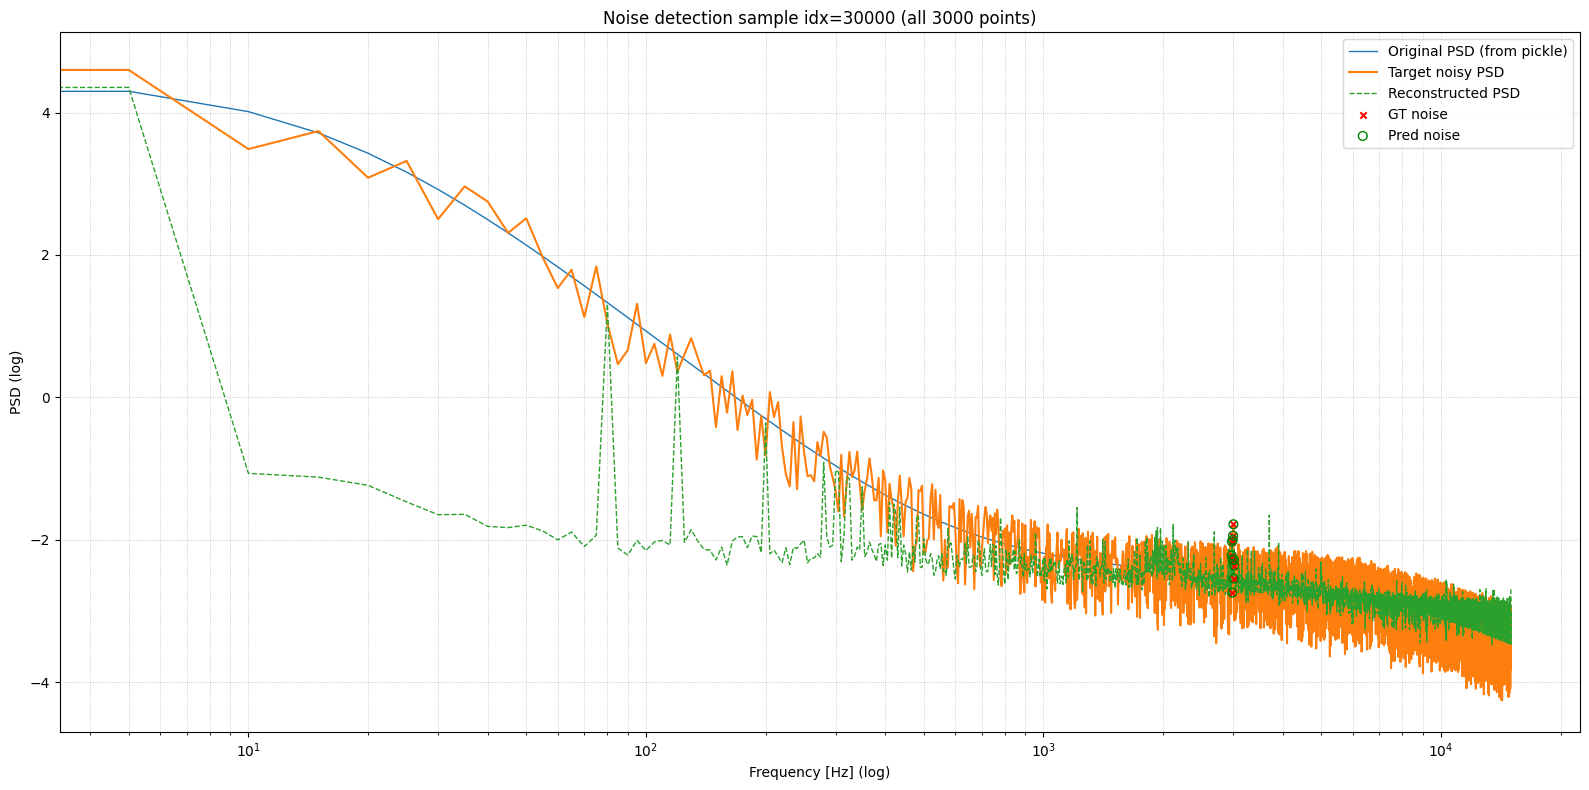

In [ ]:
PICKLE_PATH = "/content/drive/MyDrive/data_lowF_noise.pickle"  # あなたが使っているパス
OUT_DIR = str(BASE_OUT_DIR)  # train_noise_point_task の out_dir と同じもの

visualize_noise_sample(
    idx=30000,                # 見たいサンプル番号（0〜len(dataset)-1）
    pickle_path=PICKLE_PATH,
    out_dir=OUT_DIR,
)


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# checkpoint 読み込み
ckpt_path = "/content/drive/MyDrive/noise_point_output/checkpoint.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

# Dataset を再ロード（あなたのパスにする）
dataset = NoisePointDataset(
    pickle_path="/content/drive/MyDrive/data_lowF_noise.pickle",
)

# Train/Val を checkpoint と同じように split
val_ratio = 0.2
n_total = len(dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=16)
val_loader = DataLoader(val_ds, batch_size=16)

# モデルを復元
model = NoisePointBERT(
    seq_len=dataset.seq_len,
    d_model=64,
    n_heads=2,
    num_layers=2,
    dim_feedforward=128,
)
model.load_state_dict(ckpt["model_state"])
model.eval()

bce = torch.nn.BCEWithLogitsLoss()

def get_cls_loss(loader):
    total_cls = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch in loader:
            x = batch["input"]
            m = batch["mask"]
            y = batch["target"]
            label = batch["noise_label"]

            recon, logits = model(x, m)

            cls_loss = bce(logits.view(-1), label.view(-1))
            total_cls += cls_loss.item()
            total_batches += 1

    return total_cls / total_batches

train_cls_loss = get_cls_loss(train_loader)
val_cls_loss = get_cls_loss(val_loader)

print("Train CLS Loss:", train_cls_loss)
print("Val CLS Loss:", val_cls_loss)


全データセットの正規化統計を計算中...
  normalization_mean = -3.063422
  normalization_std  = 0.822959
Dataset loaded:
  Samples: 32000
  Sequence length: 3000
  Mask ratio: 0.15
  Noise level: 0.3
  Use random noise type: True


KeyboardInterrupt: 